In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import njit
from scipy.optimize import curve_fit

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
##### generate initial state #####
def reset_model(init_users, alpha, beta, gamma, c_0):
    user_opinion = np.zeros(init_users)
    user_activity = np.zeros(init_users)
    user_category = np.zeros(init_users)
    post = np.zeros((0, 3))
    
    affected = {} # create dictionary with entries in that the post one user has already seen are saved
    
    for i in range(0, init_users):
        affected[i] = [] # empty in the beginning 
        opinion = 2*np.random.beta(alpha, beta)-1 # draw opinion from beta distribution (rescaled from (0,1) to (-1,1))
        
        a = 0.1
        b = 1
        U = np.random.uniform(a, b)  # drawing the activity from a power law using the inverse CDF method
        activity = (a**(1-gamma) + (b**(1-gamma) - a**(1-gamma))*U)**(1/(1-gamma)) 
        
        # assign user categories with wanted ratio
        r = np.random.rand()    
        if r <= c_0:
            category = 0
        else:
            category = 1

        user_opinion[i] = opinion # value from continous interval [-1,1] for opinion 1 to opinion 2
        user_activity[i] = activity # value from continous interval [0,1] for probabilty of being online
        user_category[i] = category # 0 for lurker (don't post), 1 (posts)
    
    return user_opinion, user_activity, user_category, post, affected


##### weight function from the model of social differentiation #####
@njit
def f_1(opinion_a, opinion_b, epsilon, mu, F):
    
    a = F[0] 
    r = F[1]
    Omega = F[2]
    
    dist = abs(opinion_a - opinion_b)
    
    if dist <= epsilon:
        return mu*(1 - (1/epsilon)*dist)**a
    elif dist <= Omega:
        return -mu/r*((1/epsilon)*dist-1)**a
    else:
        return 0
    
##### ricker wavelet weight function #####
@njit
def RW(opinion_a, opinion_b, epsilon, mu, F):
    dist = abs(opinion_a - opinion_b)
    
    return mu * (1 - (dist/epsilon)**2) * np.exp(-0.5*(dist/epsilon)**2)
    
        
##### function determining the score of a post #####
@njit
def score(A, U, D): #age in hours, upvotes, downvotes 
    t = A*60*60
    x = U - D
    
    if x > 0:
        y = 1
    elif x == 0:
        y = 0
    elif x < 0:
        y = -1
        
    if abs(x) >= 1:
        z = abs(x)
    elif abs(x) < 1:
        z = 1

    score = y * np.log10(z) + t/45000
    
    return score



##### re-arrange all arrays if users leave/join #####
def dynamical_users(curr_users, affected, user_opinion, user_activity, user_category, index, join_rate, alpha, beta, gamma, c_0):
    joining_users = int(curr_users*join_rate)
    
    for i in index:
        affected[i] = []
        
        a = 0.1
        b = 1
        U = np.random.uniform(a, b)  
        activity = (a**(1-gamma) + (b**(1-gamma) - a**(1-gamma))*U)**(1/(1-gamma)) 

        r = np.random.rand()  
        if r <= c_0:
            category = 0
        else:
            category = 1

        user_opinion[i] = 2*np.random.beta(alpha, beta)-1
        user_activity[i] = activity 
        user_category[i] = category 

    remaining = joining_users 
        
    user_opinion = np.concatenate((user_opinion, np.zeros(remaining)), axis=0)    
    user_activity = np.concatenate((user_activity, np.zeros(remaining)), axis=0)    
    user_category = np.concatenate((user_category, np.zeros(remaining)), axis=0)    

    for i in range(remaining):
        affected[i+curr_users-1] = []
        
        a = 0.1
        b = 1
        U = np.random.uniform(a, b)  
        activity = (a**(1-gamma) + (b**(1-gamma) - a**(1-gamma))*U)**(1/(1-gamma)) 

        r = np.random.rand()  
        if r <= c_0:
            category = 0
        else:
            category = 1

        user_opinion[i+curr_users-1] = 2*np.random.beta(alpha, beta)-1
        user_activity[i+curr_users-1] = activity 
        user_category[i+curr_users-1] = category 
        
    curr_users = len(user_opinion)
    
    return curr_users, affected, user_opinion, user_activity, user_category



###### curve fit with power law for histograms #####
def power(x, a, k):
    return a*x**k

def powerlaw_check(bins, hist):
    A, B = curve_fit(power, bins[1:]-(bins[2]-bins[1])/2, hist, p0=[1, -1])
    return A

In [3]:
##### opinion dynamics of the reddit model #####

def telegram(simulation_time, curr_users, affected, user_opinion, user_activity, user_category, post, n, time, post_thres, f, epsilon, mu, F, end_param, join_rate):
    
    opinion_timeline = np.zeros((1000, int(simulation_time))) # create array for opinion timeline
    leaving_users = 0 # counting variable
    
    for t in range(0, simulation_time):
        
        # new posts are submitted 
        
        random = np.random.rand(curr_users)
        for i in range(0, curr_users):
            s = np.copy(user_activity[i])
            c = np.copy(user_category[i])

            if s >= random[i] and c == 1:  # post submitted with users opinion only when he is online and belongs to category 1 
                r = np.random.rand()

                if r <= post_thres:
                    new_post = np.array([[user_opinion[i], 0, 1]]) #  [[user opinion, duration online, seen]]
                    post = np.concatenate((post, new_post), axis=0) # add new post to array with all posts
                    add = affected[i]
                    add.append(n)
                    affected[i] = add # make sure user won't get affected by his own post again
                    n += 1 

        # users interact with posts, their opinion is changed according to the given weight-function
        
        leaving_users_index = []
        
        r = np.random.rand(curr_users)
        for i in range(0, curr_users):
            s = user_activity[i]
            c = user_category[i]

            if s >= r[i]: # check if user is online 
                endurance = int(user_activity[i]*end_param) # determine how many posts/hour the user sees, scales with activity
                reject_count = 0
                
                for k in range(0, endurance): # user scrolls -> opinion changes, deciding if he votes
                    if k == n:
                        break

                    if n-k-1 in affected[i]: # check if user already got affected by this post
                        continue
                    else:
                        add = affected[i]
                        add.append(n-k-1)
                        affected[i] = add
                    
                    post[n-k-1][2] += 1 # add that a user has interacted with the post
                    
                    uo = np.copy(user_opinion[i])  
                    po = np.copy(post[n-k-1][0])
                    opinion_diff = abs(uo - po)
                    weight = f(uo, po, epsilon, mu, F)
                    
                    if weight < 0:
                        reject_count += 1 # count if the user rejected the post 
                    
                    user_opinion[i] += weight*(po - uo)
                
                if reject_count > endurance*0.9: # check if user leaves because he rejected more than half of the posts and save index
                    leaving_users_index.append(i)
                
                
        # every post duration online increases 1h 
        for i in range(0, n):
            post[i][1] += 1
                   
        leaving_users_index = np.unique(leaving_users_index) # get rid of double indexes
        leaving_users += len(leaving_users_index) # amount of users leaving
         
        # save opinions of the first 1000 users 
            
        for k in range(1000):
            opinion_timeline[k, t] = user_opinion[k]
        
        if join_rate != 0:
            curr_users, affected, user_opinion, user_activity, user_category = dynamical_users(curr_users, affected, user_opinion, user_activity, user_category, leaving_users_index, join_rate, 
                                                                                               alpha, beta, gamma, c_0)
        
        time += 1
        print(t,'/ %i iterations'%(simulation_time), end='\r')
        
    return user_opinion, user_activity, user_category, post, time, curr_users, n, leaving_users, opinion_timeline

In [4]:
np.random.seed(1) # make results reproducable

# set parameters to initialize all users

init_users = 10**4 # initial amount of users
alpha = 5 # beta distr. parameter
beta = 5 # beta distr. parameter
gamma = 5 # exponent of activity power law distribution
c_0 = 0.5 # parameter for picking user category

user_opinion, user_activity, user_category, post, affected = reset_model(init_users, alpha, beta, gamma, c_0) # generate initial state

# set all parameters for the opinion and network model

epsilon = 0.4 # threshold for opinion difference for user to vote or change opinion
mu = 0.1 # opinion convergence parameter
F = np.array([]) # array to pass additional arguments for other weight functions 
post_thres = 0.01 # probability that a user who is online & active posts
end_param = 50 # parameter for controlling duration of browsing
join_rate = 0.0 # determining growth of community

simulation_time = 24*14 # hours
curr_users = init_users 
time = 0 # counting variable for duration of simulation
n = 0 # counting variable for amount of posts

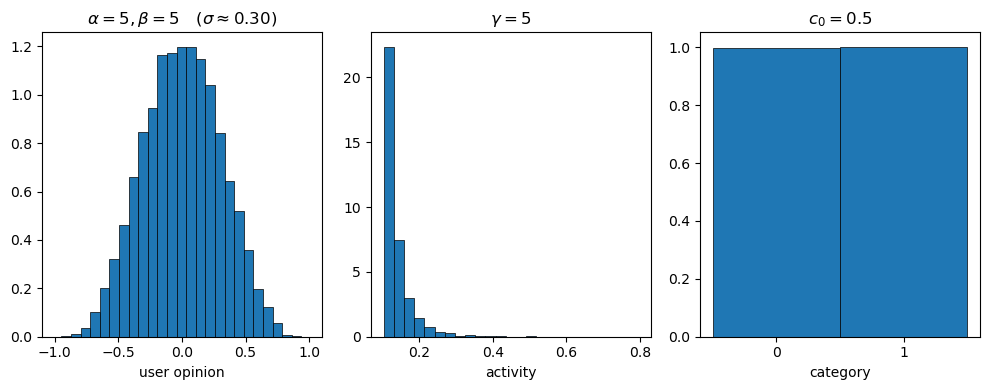

In [5]:
##### plot initial distirbutions #####

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist(user_opinion, bins=25, density='true', ec='black', lw=0.5)
ax1.set_xlim([-1.1, 1.1])
ax1.set_xlabel('user opinion')
ax1.set_title(r'$\alpha=%i, \beta=%i\quad(\sigma\approx%0.2f)$' %(alpha, beta, np.std(user_opinion)))

ax2.hist(user_activity, bins=25, density='true', ec='black', lw=0.5)
ax2.set_xlabel('activity')
ax2.set_title(r'$\gamma=%i$' %gamma)


ax3.hist(user_category, bins=2, density='true', ec='black', lw=0.5)
ax3.set_xlabel('category')
ax3.set_title(r'$c_0=%0.1f$' %(c_0))

plt.sca(ax3)
plt.xticks([0.25,0.75], [0,1])  

plt.tight_layout()

init_user_opinion = np.copy(user_opinion) # save initial opinions

In [6]:
%%time

###### run simulation #####
user_opinion, user_activity, user_category, post, time, curr_users, n, leaving_users, timelines = telegram(simulation_time, curr_users, affected, user_opinion, user_activity, user_category, 
                                                                                                         post, n, time, post_thres, RW, epsilon, mu, F, end_param, join_rate)

CPU times: user 30.2 s, sys: 71.9 ms, total: 30.2 s
Wall time: 30.3 s


Simulation time: 336 h
Amount of users: 10000
Amount of posts: 2305


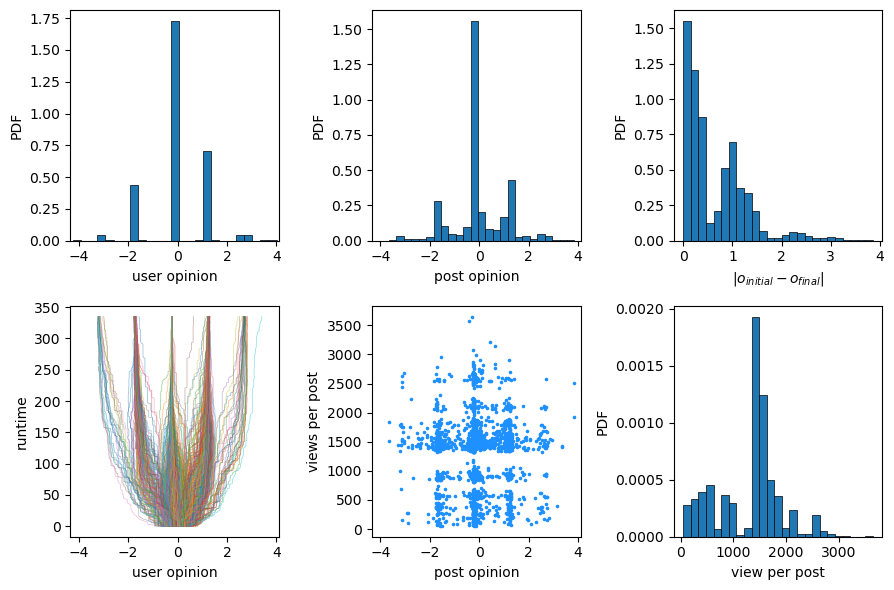

In [7]:
# plot the distirbution and statistics of the final state

print("Simulation time: %i h" %time)
print("Amount of users:", curr_users)
print("Amount of posts:", n)
#print("User leaving:", leaving_users)

fig, axs = plt.subplots(2,3, figsize=(9,6))

x_min = np.amin(user_opinion)-0.1
x_max = np.amax(user_opinion)+0.1

axs[0,0].hist(user_opinion, bins=25, density='true', ec='black', lw=0.5)
axs[0,0].set_xlabel('user opinion')
axs[0,0].set_ylabel('PDF')
axs[0,0].set_xlim([x_min,x_max])

axs[0,1].hist(post[:,0], bins=25, density='true', ec='black', lw=0.5)
axs[0,1].set_xlabel('post opinion')
axs[0,1].set_ylabel('PDF')
axs[0,1].set_xlim([x_min,x_max])

axs[0,2].hist(abs(init_user_opinion - user_opinion[:init_users]), bins=25, density='true', ec='black', lw=0.5)
axs[0,2].set_xlabel(r'$|o_{initial} - o_{final}|$')
axs[0,2].set_ylabel('PDF')


x = np.arange(0, simulation_time, 1)
for i in range(1000):
    axs[1,0].plot(timelines[i], x, lw=0.5, alpha=0.5)

axs[1,0].set_xlabel('user opinion')
axs[1,0].set_ylabel('runtime')
axs[1,0].set_xlim([x_min,x_max])

axs[1,1].scatter(post[:,0], post[:,2], s=10, marker='.', c='dodgerblue')
axs[1,1].set_xlabel('post opinion')
axs[1,1].set_ylabel('views per post')
axs[1,1].set_xlim([x_min,x_max])

axs[1,2].hist(post[:,2], bins=25, density='true', ec='black', lw=0.5)
axs[1,2].set_xlabel('view per post')
axs[1,2].set_ylabel('PDF')

plt.tight_layout()  
plt.savefig(f'tg_fixed_N={curr_users}_a={alpha}_b={beta}_y={gamma}_c0={c_0}_eps={epsilon}_mu={mu}_p={post_thres}_d={end_param}_nu={join_rate}.png', dpi=250, bbox_inches='tight')
plt.show()